In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

import sys
sys.path.append("/cds/home/h/haoyuan/Documents/my_repos/SpeckleContrastEstimation/")
from ContrastEstimation import ScatteringInfoMD

plt.rcParams.update({'font.size':22})

# Load the data

In [2]:
tic = time.time()
atomNum, spaceLimit, atomType, atomPosition  = ScatteringInfoMD.load_atom_info("./output/atomPos.20000")
toc = time.time()
print("It takes {:.2f} seconds to load the atom position".format(toc - tic))

There are 3.30e+04 atoms in this file.
It takes 0.09 seconds to load the atom position


In [3]:
# Sort according to the atom type
(atomTypeArray,
 atomTypeStartIdx,
 atomTypeCount,
 atomType,
 atomPosition) = ScatteringInfoMD.categorize_atoms(atom_types=atomType, 
                                                   position_holder=atomPosition)

# Get the wave-vectors compatible with the box

In [4]:
qArray = ScatteringInfoMD.get_q_vector_list_in_range(box_size_xyz_A=spaceLimit[:,1] - spaceLimit[:,0],
                                                     q_low_A = 0.10,
                                                     q_high_A = 0.12)

In [5]:
formFactorArray = ScatteringInfoMD.get_MD_formfactor_at_Q_list(q_list_A=qArray, 
                                                               atom_position_array=atomPosition,
                                                               atom_type_array=atomType,
                                                               atom_type_name_list=['O', 'H'])

# Generate a list of Q vectors to calculate the scattering intensity

In [6]:
qArray = np.linspace(start=0.1, stop=1, num=20)
qRange = [-0.02, 0.02]

qVectorArray = []
qVectorNum = [0,]

for qIdx in range(qArray.shape[0]):
    qVectorArray.append(ScatteringInfoMD.get_q_vector_list_in_range(box_size_xyz_A=spaceLimit[:,1] - spaceLimit[:,0],
                                                                    q_low_A = qArray[qIdx] + qRange[0],
                                                                    q_high_A = qArray[qIdx] + qRange[1],)
                       )
    qVectorNum.append(qVectorArray[-1].shape[0])
    
qVectorArray = np.ascontiguousarray(np.vstack(qVectorArray))

# Get the Intensity for each Q for each simulation

In [10]:
# Loop through all the atom configurations
for x in range(1000, 1001):
    tic = time.time()
    
    # Load the atom configuration
    (atomNum, 
     spaceLimit,
     atomType,
     atomPosition)  = ScatteringInfoMD.load_atom_info("./output/atomPos.{}".format(x * 100 + 20000))
    
    # Sort according to the atom type
    (atomTypeArray,
     atomTypeStartIdx,
     atomTypeCount,
     atomType,
     atomPosition) = ScatteringInfoMD.categorize_atoms(atom_types=atomType, 
                                                       position_holder=atomPosition)
    
    # Get the scattering intensity for the pre-selected q vectors
    intensity = ScatteringInfoMD.get_MD_formfactor_at_Q_list_parallel_at_Q(q_list_A = qVectorArray,
                                                                           atom_position_array = atomPosition,
                                                                           atom_type_array = atomType,
                                                                           atom_type_name_list = ['O', 'H'])
    
    np.save("./output/intensity.{}.npy".format(x * 100 + 20000), intensity)
    
    toc = time.time()
    print("It takes {:.2f} seconds to process 1 atom configuration".format(toc - tic))

There are 3.30e+04 atoms in this file.
It takes 0.74 seconds to process 1 atom configuration


# Load and check the scattering intensity

In [11]:
intensityHolder = []
for x in range(1001):
    intensityHolder.append(np.load("./output/intensity.{}.npy".format(x * 100 + 20000)))
    
intensityHolder = np.vstack(intensityHolder)
intensityHolder = np.square(np.abs(intensityHolder))

In [12]:
qVectorNum = np.cumsum(qVectorNum)

In [14]:
intensityPerQ = np.zeros((1001, qArray.shape[0]))

for qIdx in range(qArray.shape[0]):
    intensityPerQ[:, qIdx] = np.mean(intensityHolder[:, qVectorNum[qIdx]:qVectorNum[qIdx + 1]], axis=1)

In [15]:
meanIntensityPerQ = np.mean(intensityPerQ, axis=0)
stdIntensityPerQ = np.std(intensityPerQ, axis=0)

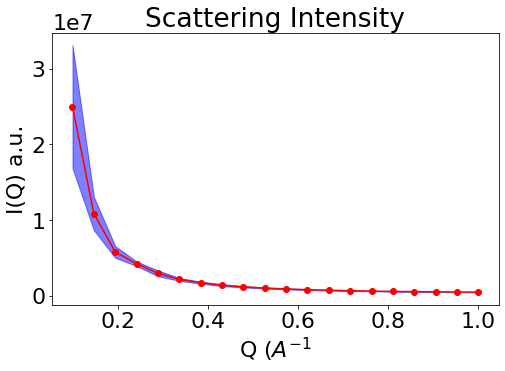

In [16]:
fig, axis=plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(8)
fig.set_figheight(5)

axis.fill_between(qArray,
                  meanIntensityPerQ - stdIntensityPerQ,
                  meanIntensityPerQ + stdIntensityPerQ,
                  color='b', alpha=0.5)
axis.plot(qArray, meanIntensityPerQ, 'ro-')
axis.set_title("Scattering Intensity")
axis.set_xlabel("Q ($A^{-1}$")
axis.set_ylabel("I(Q) a.u.")
plt.show()

# Get the g2 function

In [20]:
intensityFFT = np.fft.fft(intensityHolder, axis=0)
intensityAutoCorr = np.fft.ifft(intensityFFT * np.conjugate(intensityFFT), axis=0).real / 1001

In [21]:
intensityAutoCorrPerQ = np.zeros((1001, qArray.shape[0]))
stdIntensityAutoCorrPerQ = np.zeros((1001, qArray.shape[0]))

for qIdx in range(qArray.shape[0]):
    intensityAutoCorrPerQ[:, qIdx] = np.mean(intensityAutoCorr[:, qVectorNum[qIdx]:qVectorNum[qIdx + 1]], axis=1) / np.square(meanIntensityPerQ[qIdx]) #- 1
    stdIntensityAutoCorrPerQ[:, qIdx] = np.std(intensityAutoCorr[:, qVectorNum[qIdx]:qVectorNum[qIdx + 1]], axis=1) / np.square(meanIntensityPerQ[qIdx]) #- 1
    
    #intensityAutoCorrPerQ[:, qIdx] /= intensityAutoCorrPerQ[0, qIdx]
    #stdIntensityAutoCorrPerQ[:, qIdx] /= intensityAutoCorrPerQ[0, qIdx]

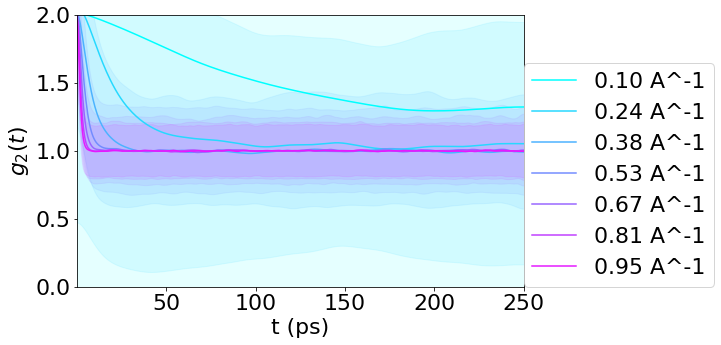

In [49]:
fig, axis=plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(8)
fig.set_figheight(5)

timeArray = np.arange(1001) * 0.5  # ps
cmap = plt.get_cmap("cool")

for qIdx in range(0, 20, 3):
    
    
    axis.fill_between(timeArray,
                      intensityAutoCorrPerQ[:, qIdx] - stdIntensityAutoCorrPerQ[:, qIdx],
                      intensityAutoCorrPerQ[:, qIdx] + stdIntensityAutoCorrPerQ[:, qIdx],
                      color=cmap(float(qIdx) / 20),
                      alpha=0.1)
    
    axis.plot(timeArray,
              intensityAutoCorrPerQ[:, qIdx],
              label="{:.2f} A^-1".format(qArray[qIdx]),
              color=cmap(float(qIdx) / 20),
             )
    
#axis.set_title("Scattering Intensity")
axis.set_xlabel("t (ps)")
axis.set_ylabel("$g_2(t)$")
axis.set_xlim([0.1,250])
#axis.set_xscale('log')
axis.set_ylim([0,2])
plt.legend(loc=(1, 0))
plt.show()

# Get $\tau$ vs Q

In [31]:
g2 = intensityAutoCorrPerQ[:, :] / intensityAutoCorrPerQ[0, qIdx, np.newaxis] * 2
tmp = np.log(g2 - 1)

/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.43-py3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


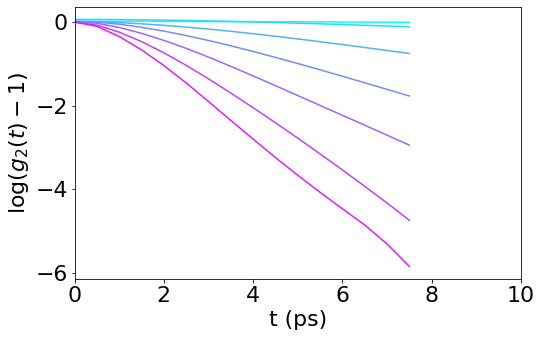

In [41]:
fig, axis=plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(8)
fig.set_figheight(5)

timeArray = np.arange(1001) * 0.5  # ps
cmap = plt.get_cmap("cool")

for qIdx in range(0, 20, 3):

    axis.plot(timeArray[0:16],
              tmp[0:16, qIdx],
              label="{:.2f} A^-1".format(qArray[qIdx]),
              color=cmap(float(qIdx) / 20),
             )
    
#axis.set_title("Scattering Intensity")
axis.set_xlabel("t (ps)")
axis.set_ylabel("log($g_2(t) - 1)$")
axis.set_xlim([0,10])
#axis.set_ylim([0,2])
#plt.legend(loc=(1, 0))
plt.show()

In [42]:
expFitCurve = np.zeros((1001, 20))
for qIdx in range(qArray.shape[0]):
    a, b, c = np.polyfit(timeArray[0:15],tmp[0:15, qIdx], deg=2)
    print(a, b, c, qArray[qIdx])
    expFitCurve[:, qIdx] = np.exp( a * timeArray ** 2 + b * timeArray + c)

-9.992329651377107e-05 -0.002977840860633076 0.02229569013248392 0.1
-0.0004248641942506583 -0.0014406536383005783 0.14158664085866599 0.1473684210526316
-0.0013880392979355202 -0.0038540904244141585 -0.05757543804835207 0.19473684210526315
-0.0025435972461609045 -0.005592713478834017 0.06622922565909636 0.24210526315789474
-0.0045917937505916976 -0.013482532789132985 -0.018171184955509134 0.2894736842105263
-0.006768406908161211 -0.02076553061303365 0.07533494853066505 0.33684210526315794
-0.009175712575394842 -0.038563041029089855 0.026741673141428696 0.38421052631578945
-0.01239308269988263 -0.05839205981694826 0.052068756942058314 0.43157894736842106
-0.015270308735036736 -0.08533774820741664 0.05744504011617339 0.4789473684210527
-0.018462957680097092 -0.11402190237819743 0.060723408420739075 0.5263157894736842
-0.018282578558014708 -0.15408192668151227 0.08416115301418357 0.5736842105263158
-0.024918835451914197 -0.19874826006213403 0.06721988423385802 0.6210526315789474
-0.02309

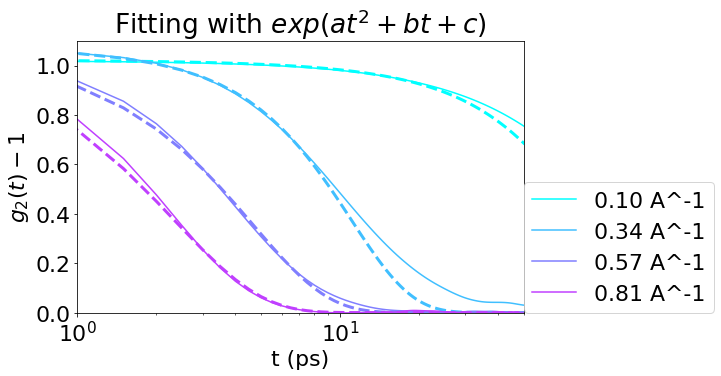

In [44]:
fig, axis=plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(8)
fig.set_figheight(5)

timeArray = np.arange(1001) * 0.5  # ps
cmap = plt.get_cmap("cool")

for qIdx in range(0, 20, 5):
    
    axis.plot(timeArray,
              (intensityAutoCorrPerQ[:, qIdx] - 1),
              label="{:.2f} A^-1".format(qArray[qIdx]),
              color=cmap(float(qIdx) / 20),
             )
    
    axis.plot(timeArray,
              expFitCurve[:, qIdx],
              linestyle='--',
              linewidth=3,
              color=cmap(float(qIdx) / 20),
             )
              
axis.set_title("Fitting with $exp(at^2 + bt +c)$")
axis.set_xlabel("t (ps)")
axis.set_ylabel("$g_2(t) - 1$")
axis.set_xlim([1, 50])
axis.set_ylim([0,1.1])

axis.set_xscale('log')

plt.legend(loc=(1, 0))
plt.show()

In [45]:
def getFWHM(coordinate, curve_values, center=False):
    """
    Get the FWHM in the straightforward way.
    However, notice that, when one calculate the FWHM in this way, the result
    is sensitive to small perturbations of the curve's shape.

    :param coordinate:
    :param curve_values:
    :param center: Whether return the coordinate of the center of the region within FWHM
    :return:
    """
    # Get the half max value
    half_max = (np.max(curve_values) + np.min(curve_values)) / 2.

    # Get the indexes for the range.
    indexes = np.arange(len(coordinate), dtype=np.int64)
    mask = np.zeros_like(indexes, dtype=bool)
    mask[curve_values >= half_max] = True

    indexes_above = indexes[mask]

    # Get the ends of the region
    left_idx = np.min(indexes_above)
    right_idx = np.max(indexes_above)

    # Convert the indexes into coordinates
    fwhm = coordinate[right_idx] - coordinate[left_idx]

    if center:
        distribution = curve_values[mask]
        distribution /= np.sum(distribution)

        coordinate_roi = coordinate[mask]

        mean = np.sum(np.multiply(distribution, coordinate_roi))

        return fwhm, mean
    else:
        return fwhm


In [53]:
fwhm = np.zeros(20)
for qIdx in range(qArray.shape[0]):
    fwhm[qIdx] = getFWHM(curve_values=intensityAutoCorrPerQ[:500, qIdx], coordinate=timeArray[:500])
    
tau = 2 * fwhm / np.log(2)

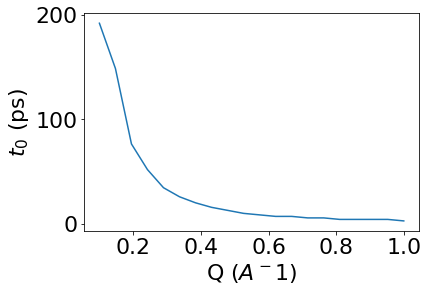

In [54]:
plt.plot(qArray, tau)
plt.xlabel("Q $(A^-1)$")
plt.ylabel("$t_0$ (ps)")
plt.show()

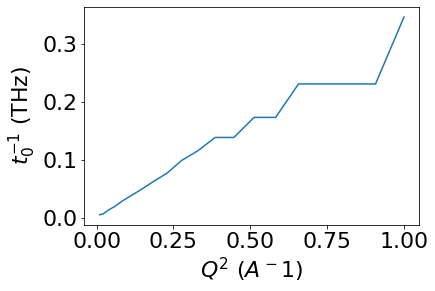

In [55]:
plt.plot(qArray ** 2, 1/tau)
plt.xlabel("$Q^2$ $(A^-1)$")
plt.ylabel("$t_0^{-1}$ (THz)")
plt.show()